In [192]:
import numpy as np
import matplotlib.pyplot as plt
import os

from tensorflow import keras
from tensorflow import shape

from keras.datasets import mnist
from keras.layers import Flatten, Reshape, Input, Dense, Lambda
import keras.backend as K


INPUT_DIM = 28
MEAN_DIM = 256
LATENT_DIM = 64


def plotDigits(*args):
    args = [x.squeeze() for x in args]
    n = min([x.shape[0] for x in args])
    
    plt.figure(figsize = (n, len(args)))
    
    for j in range(n):
        for i in range(len(args)):
            ax = plt.subplot(len(args), n, i * n + j + 1)
            plt.imshow(args[i][j])
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
    plt.show()


def countImgsFromDotDirectory():
    imgs = 0
    names = []
    for img in os.listdir():
        if ".jpg" in img:
            imgs += 1
            names.append(img)
    return imgs, names


def getArrayOfImgs():
    countInDir, imgNames = countImgsFromDotDirectory()
    arrayOfImgs = np.zeros((countInDir, 28, 28))

    for i in range(len(imgNames)):
        readImg = plt.imread(imgNames[i])
        arrayOfImgs[i] = np.array([readImg[i, j, 0] for i in range(len(readImg)) \
                                                    for j in range(len(readImg[0]))]).reshape(28, 28) / 255
    return arrayOfImgs


def arrayOfNoisyImgs(imgs):
    for i in range(len(imgs)):
        imgs[i] = addNoise(imgs[i])
    return imgs
    

def addNoise(img, noiseAmp = 0.5):
    if type(img) == np.ndarray:
        sh = img.shape
    else:
        sh = shape(img)

    img = img + K.random_normal(sh, 0.5, noiseAmp)
    img = K.clip(img, 0., 1.)
    return img
    

def createEncoder(noiser = "n"):
    encoder = keras.Sequential(name="encoder")
    encoder.add(Input(shape=(INPUT_DIM, INPUT_DIM)))
    if noiser == "y":
        encoder.add(Lambda(addNoise, name = "noiser"))
    encoder.add(Flatten())
    encoder.add(Dense(MEAN_DIM, activation="elu"))
    encoder.add(Dense(LATENT_DIM, activation="linear"))
    return encoder


def createDecoder():
    decoder = keras.Sequential(name="decoder")
    decoder.add(Dense(MEAN_DIM, activation="elu"))
    decoder.add(Dense(INPUT_DIM ** 2, activation="sigmoid"))
    decoder.add(Reshape((INPUT_DIM, INPUT_DIM)))
    return decoder


def createAE(encoder, decoder):
    autoencoder = keras.Sequential(layers=[*encoder.layers, *decoder.layers])
    autoencoder.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.BinaryCrossentropy())
    return autoencoder

In [193]:
train, test = mnist.load_data()

train = train[0] / 255
test = test[0] / 255

encoder = createEncoder()
decoder = createDecoder()
ae = createAE(encoder=encoder, decoder=decoder)

In [194]:
ae.fit(train, train, epochs = 3, batch_size = 32, validation_data = (test, test))

Epoch 1/3
1875/1875 [==============================] - 19s 9ms/step - loss: 0.1069 - val_loss: 0.0816
Epoch 2/3
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0790 - val_loss: 0.0759
Epoch 3/3
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0752 - val_loss: 0.0734


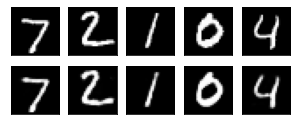

In [195]:
n = 5
imgs = test[:n]
predicted = ae.predict(imgs)

plotDigits(imgs, predicted)

In [196]:
noiseencoder = createEncoder(noiser="y")
featureExtractor = keras.Model(
    inputs = noiseencoder.inputs,
    outputs = noiseencoder.get_layer(name="noiser").output
)

noisedecoder = createDecoder()
dae = createAE(encoder=noiseencoder, decoder=noisedecoder)
train2, test2 = mnist.load_data()

x_train2 = train2[0] / 255
x_test2 = test2[0] / 255

In [197]:
dae.fit(x_train2, x_train2, epochs = 3, batch_size = 32, validation_data = (x_test2, x_test2))

Epoch 1/3
1875/1875 [==============================] - 41s 11ms/step - loss: 0.1661 - val_loss: 0.1360
Epoch 2/3
1875/1875 [==============================] - 18s 9ms/step - loss: 0.1314 - val_loss: 0.1259
Epoch 3/3
1875/1875 [==============================] - 17s 9ms/step - loss: 0.1248 - val_loss: 0.1223


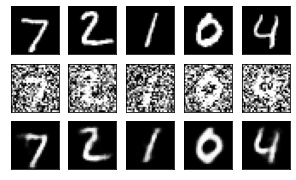

In [198]:
n = 5
imgs = x_test2[:n]

predicted = dae.predict(imgs)
features = featureExtractor(predicted).numpy()

plotDigits(imgs, features, predicted)

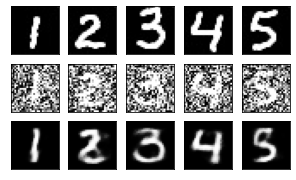

In [199]:
arrim = getArrayOfImgs()

predicted = dae.predict(arrim)
features = featureExtractor(predicted).numpy()

plotDigits(arrim, features, predicted)